# 프로젝트 : Segmentation map으로 도로 이미지 만들기

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 데이터 준비하기
___

In [ ]:
import os

data_path = '/content/drive/MyDrive/aiffel/conditional_generation/data/cityscapes/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1000


- 이미지를 한번 보자.

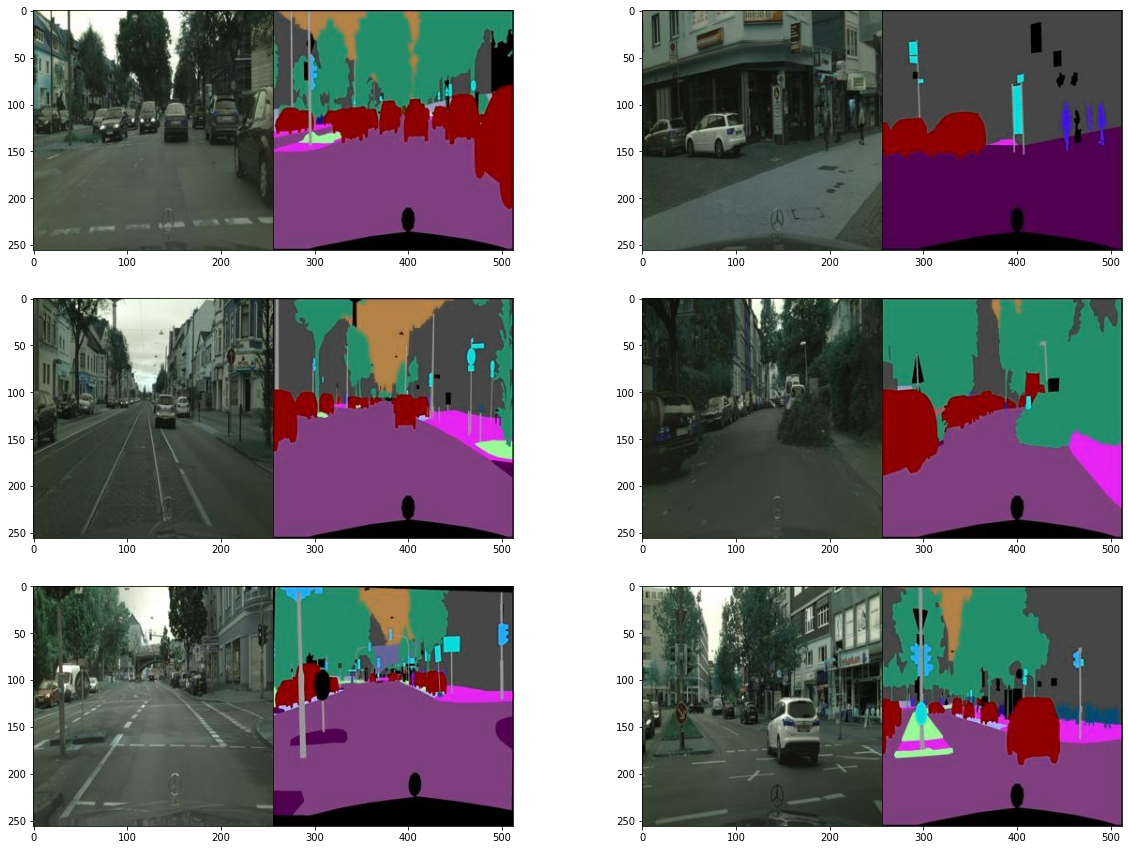

In [ ]:
#임의의 6장 선택 후 시각화
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
for i in range(1, 7):
    file = data_path + os.listdir(data_path)[np.random.randint(1000)]
    img = cv2.imread(file, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

In [ ]:
#이미지 크기 확인
file = data_path + os.listdir(data_path)[0]
img = cv2.imread(file, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


- 이미지 크기가 (256, 512, 3)이므로 모델 학습에 사용할 데이터는 (256, 256, 3) 크기의 2개 이미지로 분할하여 사용할 것.

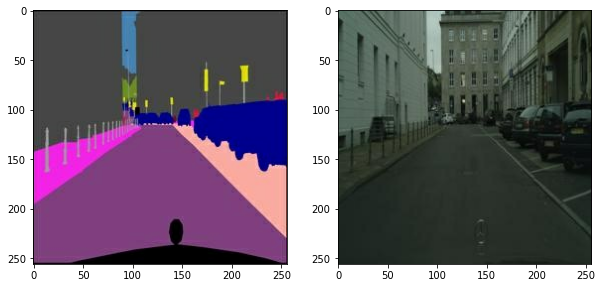

In [ ]:
#(256, 256, 3) 크기의 2개 이미지로 분할
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    real_image = img[:, :w, :] 
    real_image = tf.cast(real_image, tf.float32)
    input_image = img[:, w:, :] 
    input_image = tf.cast(input_image, tf.float32)
    return normalize(input_image), normalize(real_image)

file = data_path + os.listdir(data_path)[1]
input_image, real_image = load_img(file)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(input_image))
plt.subplot(1,2,2); plt.imshow(denormalize(real_image))

### Augmentation 적용하기

- 학습 데이터는 1000개 뿐이므로 데이터의 다양성을 높이기 위해 augmentation 적용
- apply_augmentation 함수
    - 두 이미지가 채널 축으로 연결되고 이 결과에 각 50% 확률로 Refection padding 또는 constant padding이 30픽셀의 pad width 만큼 적용
    - 위의 결과에서 (256,256,6) 크기를 가진 이미지를 임의로 잘라내고 이 결과를 50% 확률로 가로로 뒤집음.
    - 위의 결과를 50% 확률로 세로로 뒤집고 다시 50%의 확률로 회전시킴.

In [ ]:
#augmentation 방법 적용

from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() #빠른 텐서플로 연산을 위해 @tf.function()을 사용.

#스케치 및 채색된 2개 이미지를 입력으로 받아 여러 가지 연산을 두 이미지에 동일하게 적용하는 함수.
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]

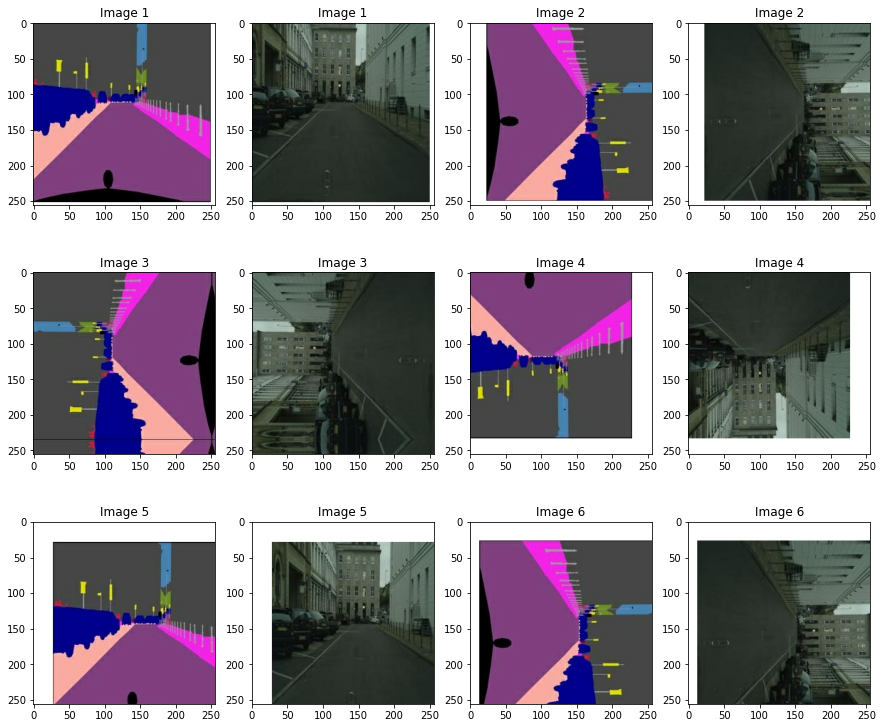

In [ ]:
#데이터에 augmentation 적용이 되었는지 확인

plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_input, augmented_real = apply_augmentation(input_image, real_image)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_input)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1) 
    plt.imshow(denormalize(augmented_real)); plt.title(f"Image {img_n}")
    img_n += 1

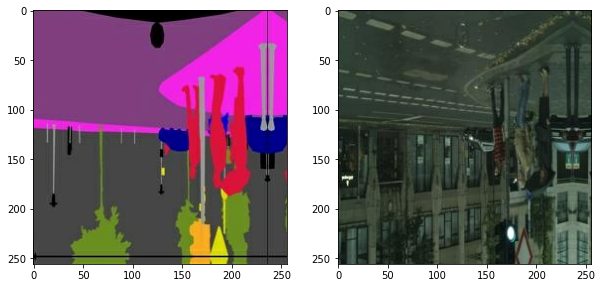

In [ ]:
#학습할 모든 데이터에 augmentation 적용 후 확인

from tensorflow import data

def get_train(img_path):
    input_image, real_image = load_img(img_path)
    input_image, real_image = apply_augmentation(input_image, real_image)
    return input_image, real_image

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
input_image, real_image = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(input_image[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(real_image[0].astype(np.uint8))

### Generator 구성하기

- Encoder와 Decoder 사이를 skip connection으로 연결한 U-Net Generator 사용
- Encoder : 블록을 통과할수록 (width, height) 크기는 반씩 줄어들고, 사용된 필터의 수는 최대 512개로 늘어나 최종 (1,1,512)로 알맞은 크기가 출력
- Decoder : 블록을 통과할수록 (width, height) 크기가 점점 늘어나고, 사용 필터의 수는 점점 줄어들어 최종 (256,256,3) 크기로 출력

In [ ]:
#인코더 및 디코더에 사용되는 기본적인 블록

from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

In [ ]:
#U-Net Generator 정의

class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [ ]:
#U-Net 구조 Generator 내부의 각 출력이 적절한지 확인
UNetGenerator().get_summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 encode_block (EncodeBlock)     (None, 128, 128, 64  3072        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 encode_block_1 (EncodeBlock)   (None, 64, 64, 128)  131584      ['encode_block[0][0]']           
                                                                                              

### Discriminator 구성하기

- 두 개의 (256,256,3) 크기 입력으로 최종 (30,30,1) 출력을 만듦.


In [ ]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x

In [ ]:
#각 출력의 크기 확인
inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 32)]    0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 130, 130, 32)     0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 127, 127, 64)      32768     
                                                                 
 batch_normalization_15 (Bat  (None, 127, 127, 64)     256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 127, 127, 64)      0         
                                                                 
Total params: 33,024
Trainable params: 32,896
Non-trainable

In [ ]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        #첫 번째 블록은 단순한 연결(concat)을 수행.
        self.block1 = layers.Concatenate()
        
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        
        #Discriminator의 최종 출력은 sigmoid 활성화를 사용.
        self.sigmoid = layers.Activation("sigmoid")
        
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()

In [ ]:
#각 블록의 출력 크기 확인
Discriminator().get_summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_7 (Concatenate)    (None, 256, 256, 6)  0           ['input_3[0][0]',                
                                                                  'input_4[0][0]']          

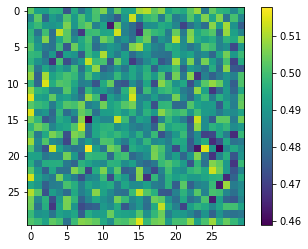

In [ ]:
#임의의 (256,256,3) 크기의 입력을 넣어 나오는 (30,30) 출력을 시각화
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

- (30,30) 크기를 갖는 결과 이미지의 각 픽셀값은 원래 입력의 (70,70) 패치에 대한 분류 결과
- 전체 입력의 크기가 (256,256) 이므로 각각의 (70,70) 패치는 원래 입력상에서 많이 겹쳐있을 것
- 각각의 픽셀값은 sigmoid 함수의 결괏값이므로 0~1 사이의 값을 가지며, 진짜 및 가짜 데이터를 판별해내는 데 사용

### Generator와 Discriminator 학습하기

In [ ]:
#GAN 손실함수와 L1을 추가로 이용
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

- Generator의 손실함수
    - fake_disc는 Generator가 생성한 가짜 이미지를 Discriminator에 입력하여 얻어진 값으로 실제 이미지를 뜻하는 "1"과 비교하기 위해 tf.ones_like()를 사용
    - L1 손실을 계산하기 위해 생성한 가짜 이미지(fake_output)와 실제 이미지(real_output) 사이의 MAE(Mean Absolute Error)를 계산


- Discriminator의 손실함수
    - 가짜 및 진짜 이미지가 Discriminator에 각각 입력되어 얻어진 값으로 실제 이미지를 잘 구분해 내야 하므로 real_disc는 "1"로 채워진 벡터와 비교하고, fake_disc는 "0"으로 채워진 벡터와 비교함.

In [ ]:
#사용할 optimizer 
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(4e-5, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-3, beta_1=.5, beta_2=.999)

In [ ]:
#하나의 배치 크기만큼 데이터를 입력했을 때 가중치를 1회 업데이트하는 과정
@tf.function
def train_step(input_image, real_image):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        
        #Generator 예측
        gen_output = generator(input_image, training=True)
        
        #Discriminator 예측
        fake_disc = discriminator(input_image, gen_output, training=True)
        real_disc = discriminator(input_image, real_image, training=True)
        
        #Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(gen_output, real_image, fake_disc)
        
        #λ는 학습 과정에서 L1 손실을 얼마나 반영할 것인지를 나타내며 논문에서는 λ=100을 사용
        gene_total_loss = gene_loss + (100 * l1_loss)   #L1 손실 반영 λ=100
        
        #Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

In [ ]:
#학습
EPOCHS = 100

generator = UNetGenerator()
discriminator = Discriminator()
history = {'gen_loss':[], 'l1_loss':[], 'disc_loss':[]}

for epoch in range(1, EPOCHS+1):
    for i, (input_image, real_image) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(input_image, real_image)
        history['gen_loss'].append(g_loss)
        history['l1_loss'].append(l1_loss)
        history['disc_loss'].append(d_loss)
                
        #200회 반복마다 손실 출력
        if (i+1) % 200 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[200]                     
Generator_loss:1.3992                     
L1_loss:0.2314                     
Discriminator_loss:0.5650

EPOCH[2] - STEP[200]                     
Generator_loss:1.9122                     
L1_loss:0.1876                     
Discriminator_loss:0.5667

EPOCH[3] - STEP[200]                     
Generator_loss:1.9265                     
L1_loss:0.2712                     
Discriminator_loss:1.2485

EPOCH[4] - STEP[200]                     
Generator_loss:2.1696                     
L1_loss:0.1766                     
Discriminator_loss:1.0600

EPOCH[5] - STEP[200]                     
Generator_loss:2.1591                     
L1_loss:0.1937                     
Discriminator_loss:2.0320

EPOCH[6] - STEP[200]                     
Generator_loss:0.8476                     
L1_loss:0.1956                     
Discriminator_loss:0.8521

EPOCH[7] - STEP[200]                     
Generator_loss:0.8923                     
L1_loss:0.2022             

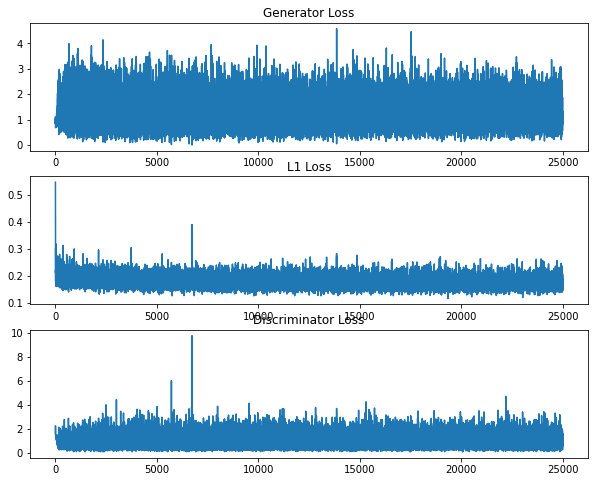

In [ ]:
#학습 결과 시각화
plt.figure(figsize=(10,8))

plt.subplot(311)
plt.plot(history['gen_loss'])
plt.title('Generator Loss')

plt.subplot(312)
plt.plot(history['l1_loss'])
plt.title('L1 Loss')

plt.subplot(313)
plt.plot(history['disc_loss'])
plt.title('Discriminator Loss')

plt.show()

### Model Test

In [ ]:
test_path = '/content/drive/MyDrive/aiffel/conditional_generation/data/cityscapes/val/'

print("number of train examples :", len(os.listdir(test_path)))

number of train examples : 5


In [ ]:
#도로 이미지 만들기
for i in range(5):
    f = test_path + os.listdir(test_path)[i]
    input_image, real_image = load_img(f)

    pred = generator(tf.expand_dims(input_image, 0))
    pred = denormalize(pred)

    plt.figure(figsize=(20,10))
    plt.subplot(1,3,1); plt.imshow(denormalize(input_image)); plt.title('Input Image', fontsize=15)
    plt.subplot(1,3,2); plt.imshow(pred[0]); plt.title('Predicted Image', fontsize=20)
    plt.subplot(1,3,3); plt.imshow(denormalize(real_image)); plt.title('Ground Truth', fontsize=15)

Output hidden; open in https://colab.research.google.com to view.

### optimizer set 1
- gene_opt = optimizers.Adam(4e-5, beta_1=.5, beta_2=.999)
- disc_opt = optimizers.Adam(2e-3, beta_1=.5, beta_2=.999)

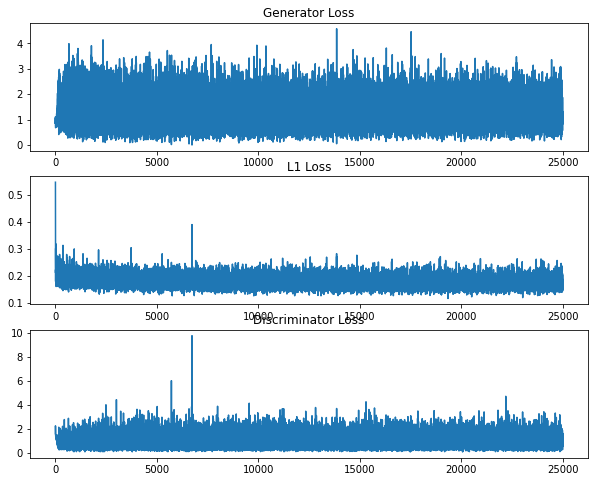

### optimizer set 2
- gene_opt = optimizers.Adam(8e-4, beta_1=.5, beta_2=.999)
- disc_opt = optimizers.Adam(2e-3, beta_1=.5, beta_2=.999)

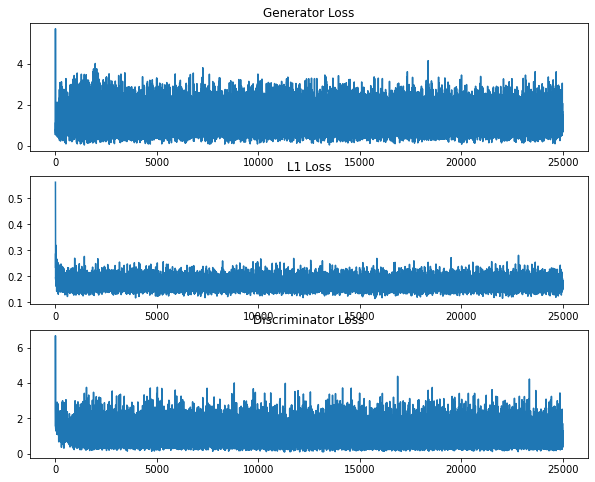

### optimizer set 3
- gene_opt = optimizers.Adam(4e-4, beta_1=.5, beta_2=.999)
- disc_opt = optimizers.Adam(2e-3, beta_1=.5, beta_2=.999)

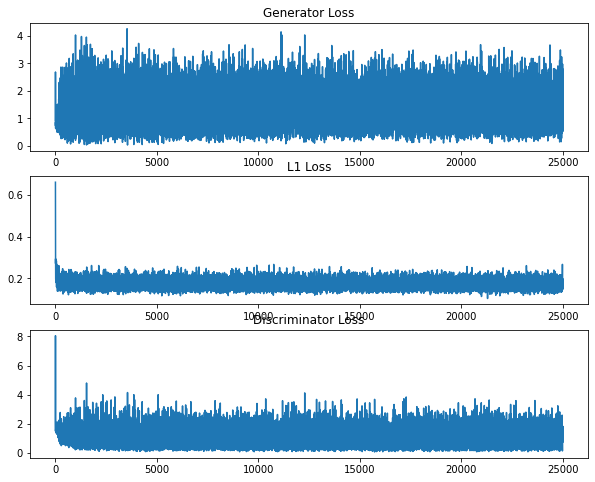

### optimizer set 4
- gene_opt = optimizers.Adam(2e-2, beta_1=.5, beta_2=.999)
- disc_opt = optimizers.Adam(2e-3, beta_1=.5, beta_2=.999)

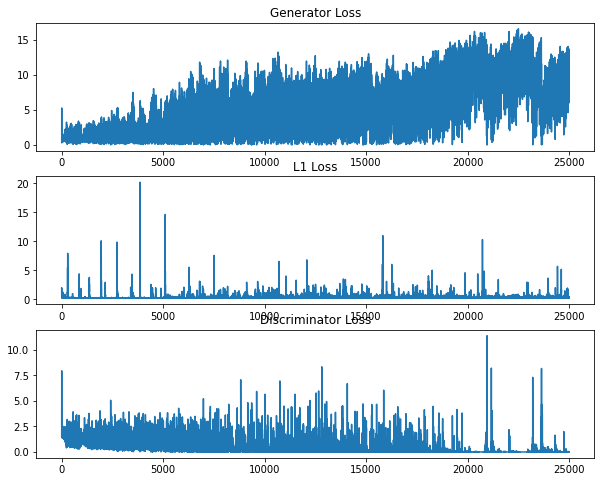

## 회고

### Loss
- L1 loss는 줄어들었지만 다른 두 loss는 줄어들지 않았다. 
- Discriminator loss는 아주 약간 감소하는 경향을 보이긴 했지만 Generator loss는 전혀 아니었다. 
- Loss에 대해서도 만족스러운 결과가 나오려면 충분히 많은 에폭을 수행하거나 모델 구조에 변화를 주어야 할 것 같다.

### 최종 정리

- Epoch의 수를 늘리면 성능이 더 좋아지겠지만, 시간이 많이 걸릴 것이므로 Epoch를 100로 설정해서 돌려봤다.
- 오히려 이미지의 학습 과정을 볼 수 있어서 나름의 의미가 있었다.
- 입력 이미지를 넣어서 예측한 이미지의 성능이 충분히 좋진 않았지만 위의 그림 중 마지막 그림을 보면 건물 창문의 윤곽선이 드러나기 시작했음을 확인할 수 있다.
- 또한 색깔이 다양해지고 Input 이미지의 윤곽선 내부의 디테일이 보이기 시작했다. Epoch의 수를 늘린다면 충분히 Ground Truth와 유사한 결과가 나올 것임을 예측할 수 있다.
- Predicted Image에서 픽셀의 모습을 확인할 수 있는데 여기서 Pix2pix가 픽셀을 기준으로 학습한다는 것을 확인할 수 있었다.
- Predicted Image의 도로 부분이 파란색, 초록색, 빨간색의 혼합인 걸로 보아 색깔을 rgb의 조합으로 재현하는 과정을 볼 수 있었다.
- 시도해 보았던 노트북 파일을 같이 첨부하였다.
